# Problem Description

The following dataset includes data of credit card users. By using supervised learning, I hope to identify clusters of customers that can be easily explained. This could be used for identifying at-risk users that should be sent resources for managing credit card debt and information on how to use credit responsibly. It could also be used to identify credit line increases or offers for responsible users.

# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Import data
# The data can be found from this kaggle competition: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
data = pd.read_csv('/kaggle/input/ccdata/CC GENERAL.csv')

# View columns, rows and data types
print(data.info())

#View the first 5 rows of the data
print(data.head())

# View the stats of each column
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

There are 8950 rows of data. Nearly all rows have non-null values, but CREDIT_LIMIT and MINIMUM_PAYMENTS will need to have their null rows dropped. 

We will look at histograms shortly to look if there are outliers that need to be removed. These columns clearly will need to be standardized after outlier removal. Also, the customer id column will be dropped as it is not relevant nor helpful to the prediction.

For this dataset, there is no dependent variable that needs to be dropped as this is an unsupervised clustering problem. There's also no concern about an unbalanced dataset since there is no classification to predict upon.

In [3]:
# First and foremost, lets drop the CUST_ID column, and remove rows with null values
data = data.drop(['CUST_ID'], axis=1)

# Remove rows with null values
data = data.dropna()

# Check out the info property of the DF to verify both of these went through:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8636 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8636 non-null   float64
 1   BALANCE_FREQUENCY                 8636 non-null   float64
 2   PURCHASES                         8636 non-null   float64
 3   ONEOFF_PURCHASES                  8636 non-null   float64
 4   INSTALLMENTS_PURCHASES            8636 non-null   float64
 5   CASH_ADVANCE                      8636 non-null   float64
 6   PURCHASES_FREQUENCY               8636 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8636 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8636 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8636 non-null   float64
 10  CASH_ADVANCE_TRX                  8636 non-null   int64  
 11  PURCHASES_TRX                     8636 non-null   int64  
 12  CREDIT_LIMI

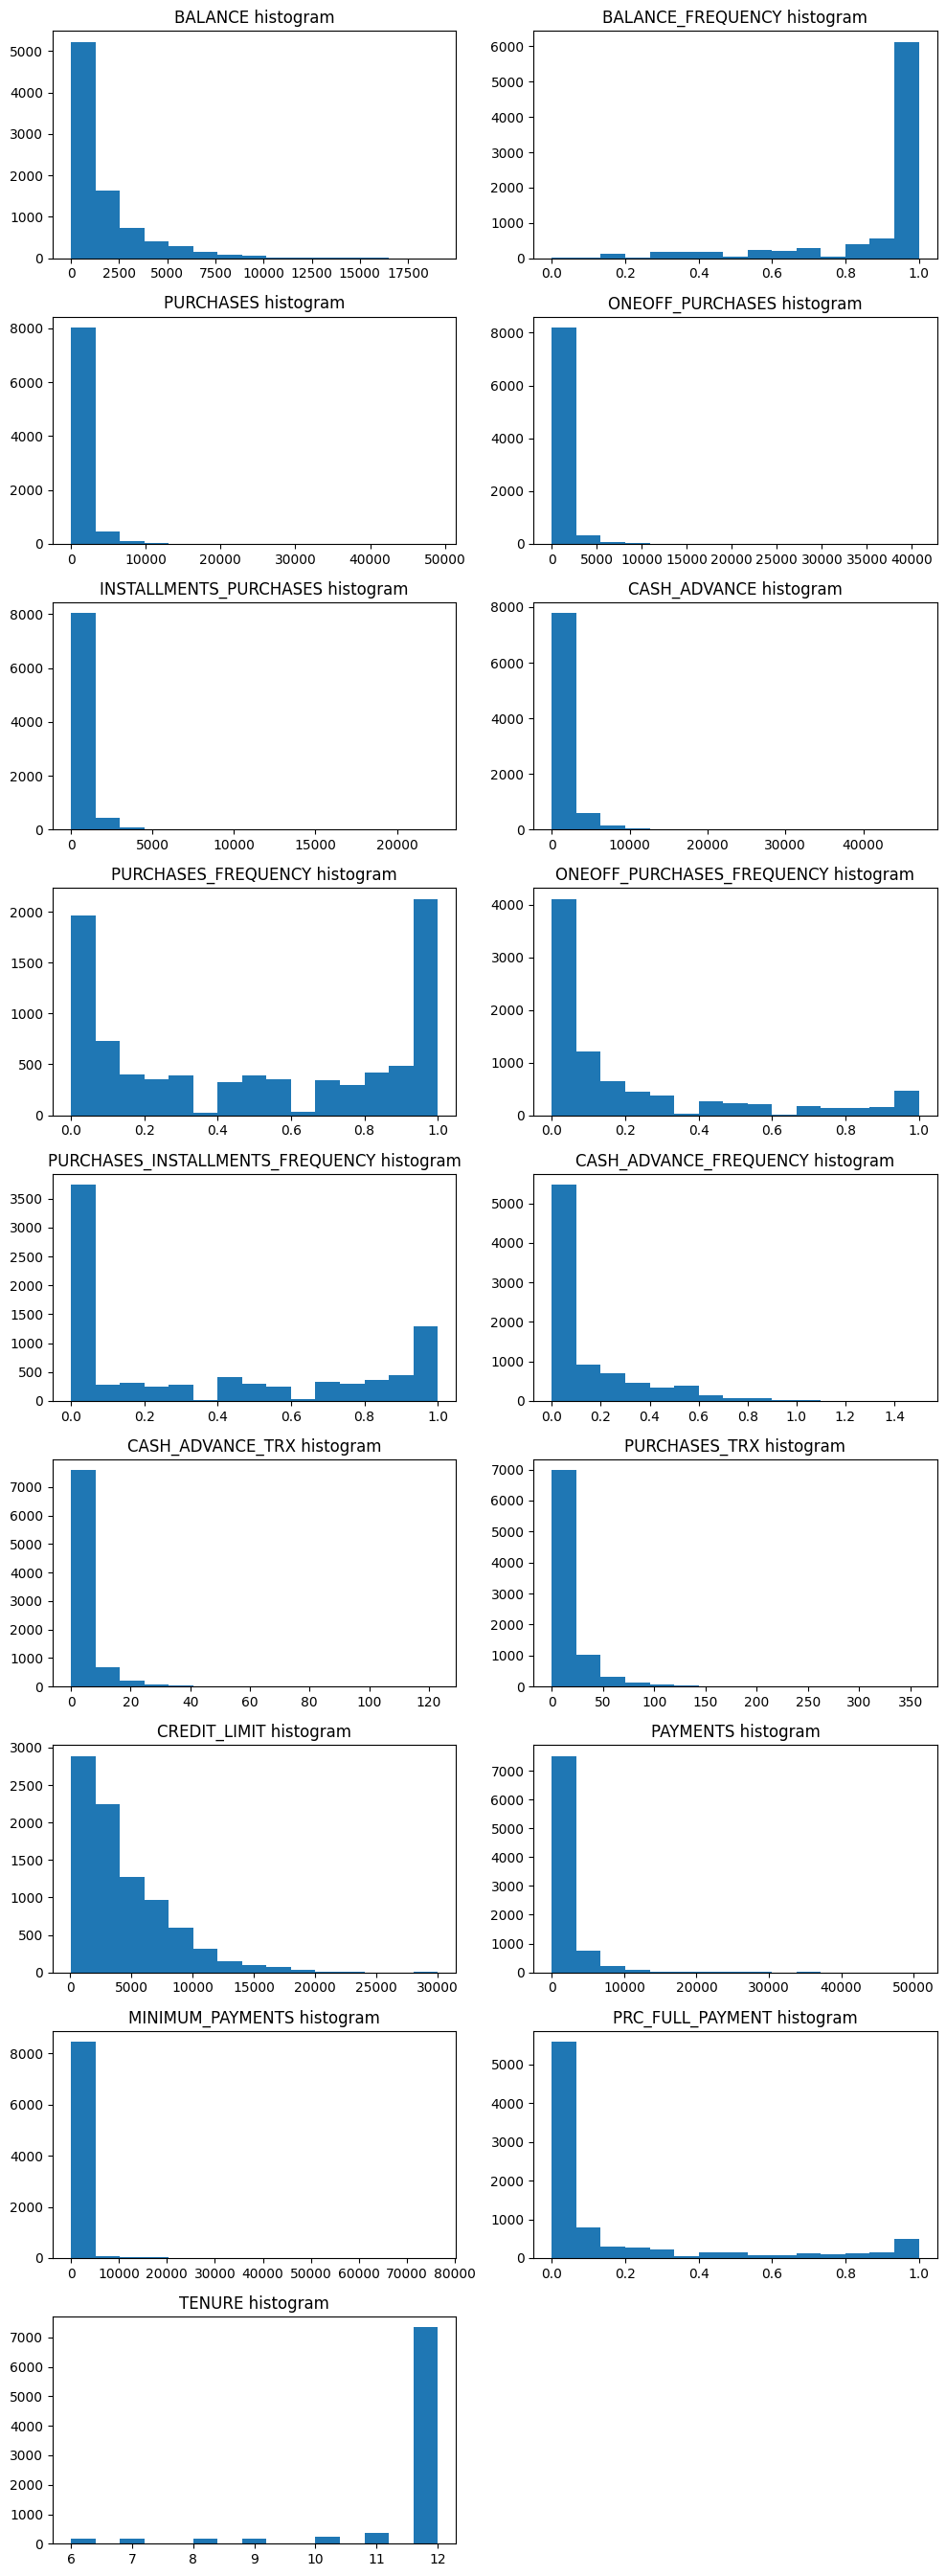

In [4]:
# View a histogram of each column
n_cols = 2
n_rows = int(np.ceil(len(data.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    axes[i].hist(data[column], bins=15)
    axes[i].set_title(column + ' histogram')

if len(data.columns) % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

There are some outliers going on in multiple features, including MINIMUM_PAYMENTS and PAYMENTS column.

In [5]:
# Find the rows that have an outlier in the MINIMUM_PAYMENTS column
outliers_df = data[(data['MINIMUM_PAYMENTS'] > 30000)]

# Show the rows with outliers
print(outliers_df)

           BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
567    3457.086184                1.0    2448.60              0.00   
1130   6090.522273                1.0      22.16             22.16   
4376  10571.411070                1.0    7739.48              0.00   
4462   4976.028578                1.0     900.87              0.00   
5298   5044.179003                1.0     966.60              0.00   
5657   4628.109931                1.0     912.54              0.00   
5830   8038.893195                1.0       0.00              0.00   
5968   6022.224462                1.0       0.00              0.00   
7132   9024.812044                1.0       0.00              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
567                  2448.60      0.000000             1.000000   
1130                    0.00      0.000000             0.083333   
4376                 7739.48      0.000000             1.000000   
4462                  900.87   

Through this we can see that the outliers in the MINIMUM_PAYMENTS column are not necessarily outliers in the other columns.

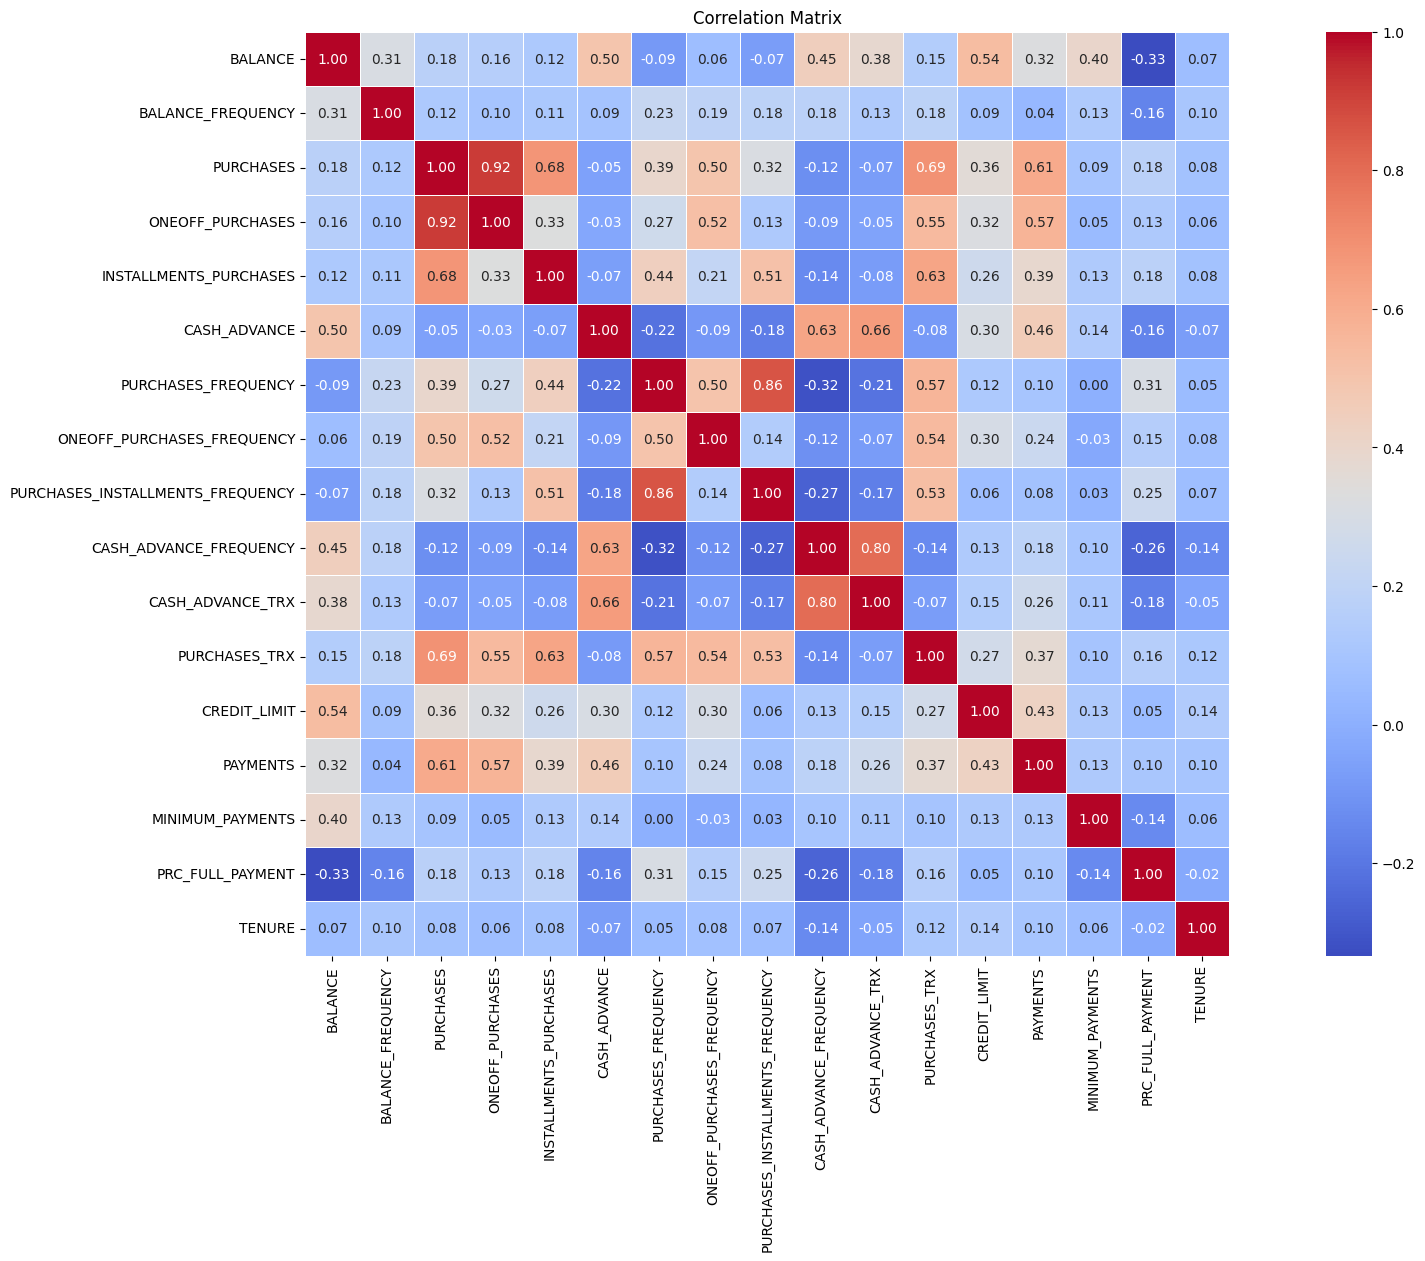

In [6]:
# Make a correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(25, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

While dropping features that have collinearity isn't as necessary for an unsupervised problem compared to a linear supervised problem, dropping features with redundant information can assist with clustering performance by relieving the curse of dimensionality. Given the nuance of these features, instead of dropping them I'll use Principal Component Analysis to reduce the amount of dimensions while keeping the majority of information given by the explained variance.

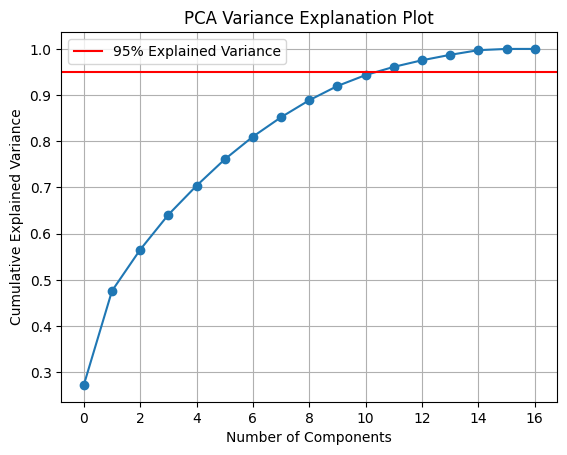

In [7]:
# Standardize data before conducting PCA
data_standardized = StandardScaler().fit_transform(data)
pca = PCA(random_state=99).fit(data_standardized)
pca_components = pca.transform(data_standardized)
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_evr = np.cumsum(explained_variance)

# Plotting
plt.plot(cumulative_evr, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explanation Plot')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.legend()
plt.show()

This plot shows that we can explain nearly half of the variance with just one component. With 10 components, nearly 95% of the variance is explained, which will be used to reduce dimensionality.

In [8]:
pca = PCA(n_components=10, random_state=99).fit(data_standardized)
pca_components = pca.transform(data_standardized)

# Analysis

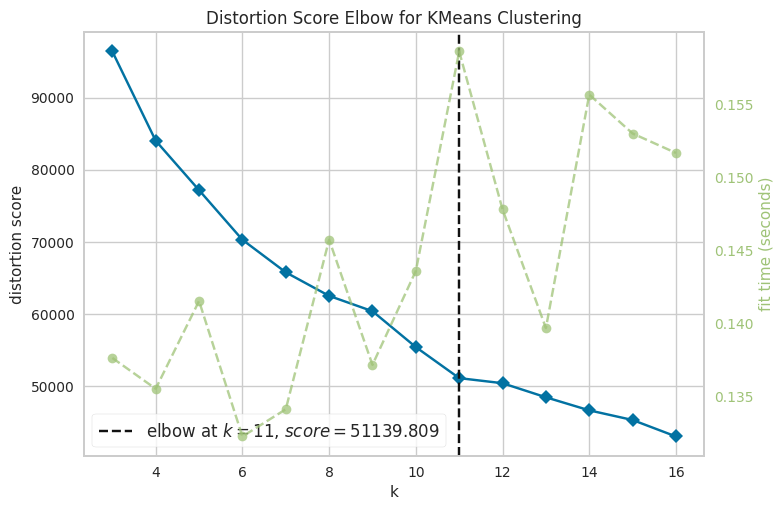

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# https://atsushihara.medium.com/finding-the-optimal-cluster-size-with-yellowbrick-f0d2df9d107b - original article that pointed me to the yellowbrick library
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html - used example code from documentation
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=99, n_init='auto')
visualizer = KElbowVisualizer(model, k=(3, 17))

visualizer.fit(pca_components)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

This tool uses the Elbow method with distortion score in order to find that the ideal amount of clusters is 11. 

In [10]:
km = KMeans(n_clusters=11, random_state=99, n_init='auto')
clusters = km.fit_predict(pca_components)

silhouette_result = silhouette_score(pca_components, clusters)

print("Silhouette score:", silhouette_result)

Silhouette score: 0.24207766845373133


Using silhouette score on a 11 cluster KMeans model, the model achieves a .242 score, which is a decent. Silhouette score ranges from -1 to 1, so the model is conducting some amount of useful clustering. 

I'll finish off using the PCA data with the yellowbricks library again but using silhouette score to verify 11 clusters is the best choice.

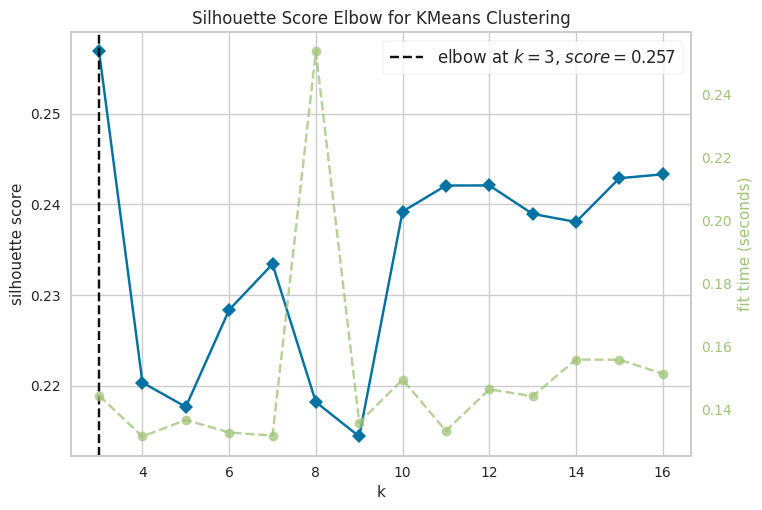

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [11]:
visualizer = KElbowVisualizer(model, k=(3,17), metric='silhouette')

visualizer.fit(pca_components)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

There's a very different picture shown here when using silhouette score instead of distortion score. The best cluster amount seems to clearly be 3 given the sharp decrease with 4 and 5 clusters, and the fact that it never surpasses the score of 3 clusters again. It's better to chose the simpler model, so 3 clusters is the way to go.

Now, I'll do this process again, but with just standardized data instead of PCA components to see if it comes to a different conclusion.

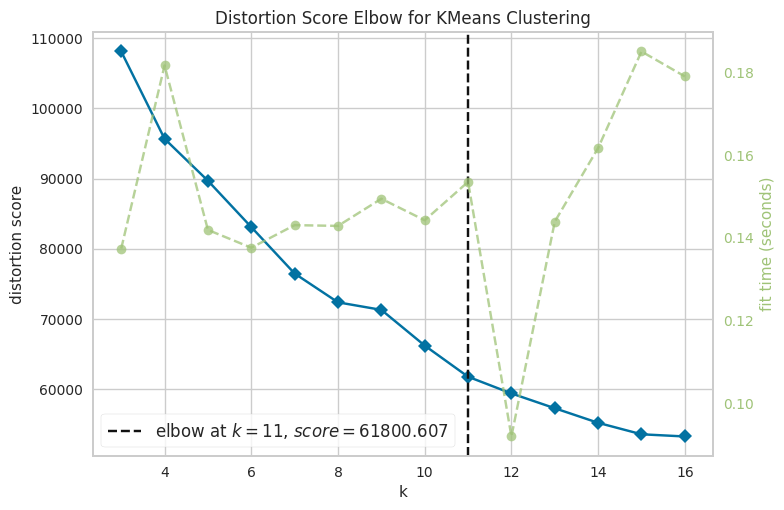

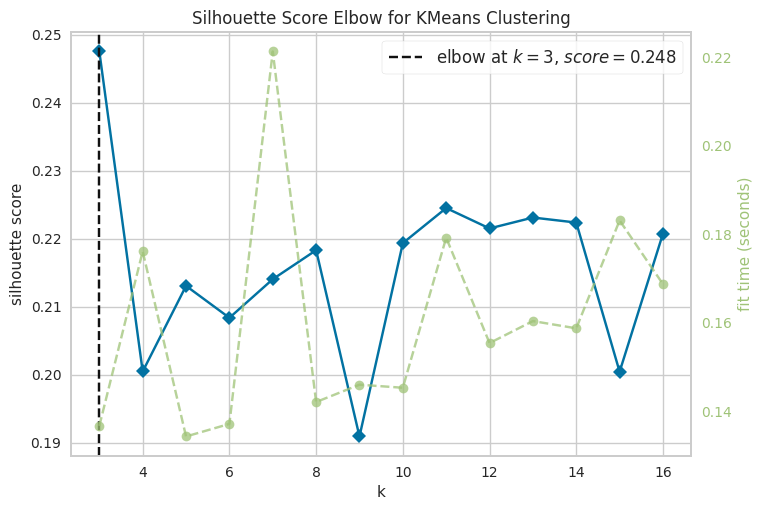

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [12]:
model = KMeans(random_state=99, n_init='auto')

# Distortion score
visualizer = KElbowVisualizer(model, k=(3, 17))
visualizer.fit(data_standardized)
visualizer.show()

# Silhouette score
visualizer = KElbowVisualizer(model, k=(3,17), metric='silhouette')
visualizer.fit(data_standardized)
visualizer.show()

We can see that we're achieving a lower distortion score and a higher silhouette score with the PCA data instead of just the standardized data with all of the columns. It appears that 3 clusters is the way to go. Now, I'll drop the outliers, standardize and run PCA again to see if the results differ.

In [13]:
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe - this stackoverflow provides code to remove outliers using zscore
data_cleaned = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

In [14]:
data_cleaned.shape

(7190, 17)

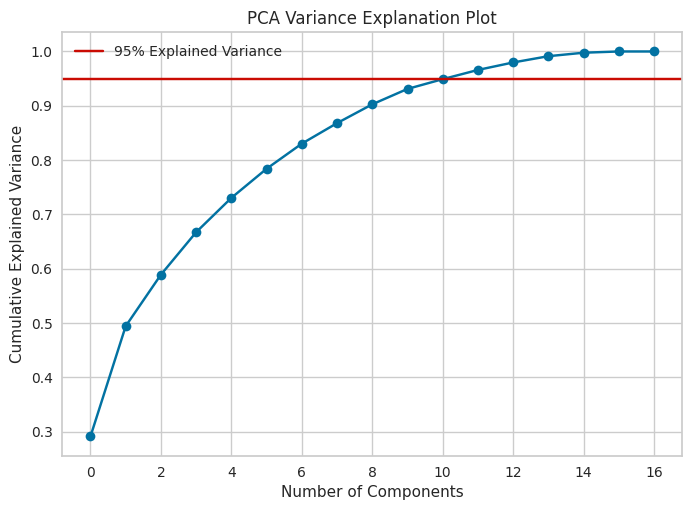

In [15]:
# Standardize data before conducting PCA
data_cleaned_standardized = StandardScaler().fit_transform(data_cleaned)
pca_cleaned = PCA(random_state=99).fit(data_cleaned_standardized)
pca_cleaned_components = pca_cleaned.transform(data_cleaned_standardized)
# Explained variance ratio
explained_variance = pca_cleaned.explained_variance_ratio_
cumulative_evr = np.cumsum(explained_variance)

# Plotting
plt.plot(cumulative_evr, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explanation Plot')
plt.grid(True)
plt.axhline(y=0.95, color='r', label='95% Explained Variance')
plt.legend()
plt.show()

After removing outliers, it is still the case that 10 components explain roughly 95% of the variance, so that will be kept the same.

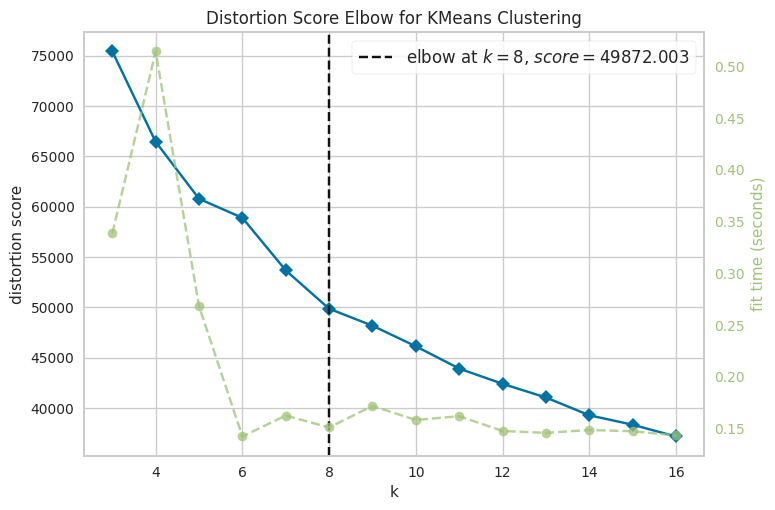

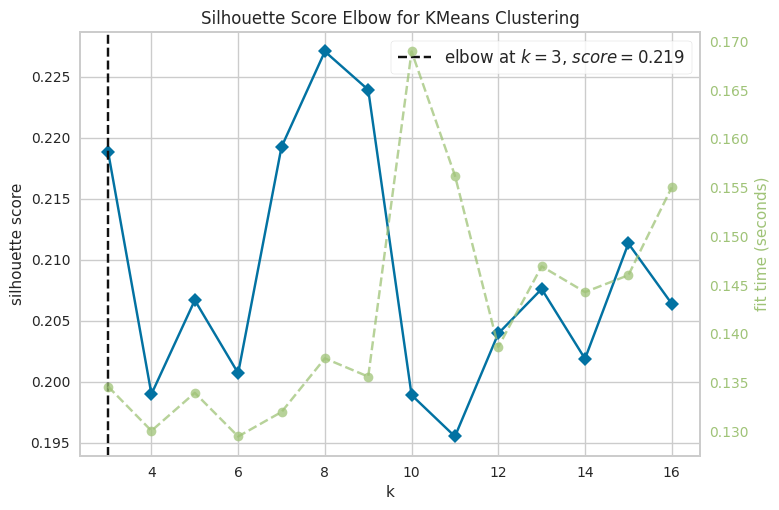

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
model = KMeans(random_state=99, n_init='auto')

pca_cleaned = PCA(n_components=10, random_state=99).fit(data_cleaned_standardized)
pca_cleaned_components = pca_cleaned.transform(data_cleaned_standardized)

# Distortion score
visualizer = KElbowVisualizer(model, k=(3, 17))
visualizer.fit(pca_cleaned_components)
visualizer.show()

# Silhouette score
visualizer = KElbowVisualizer(model, k=(3,17), metric='silhouette')
visualizer.fit(pca_cleaned_components)
visualizer.show()

With outliers removed, there is now a different picture painted by these graphs. While the silhouette score selects 3 clusters as the best again, 8 clusters has the best silhouette score which aligns with the distortion score's assessment. Even though the silhouette score is not as large as it was with the outliers in the dataset, the distortion score is much less.

Given [this explanation of distortion score vs. silhouette score](https://stats.stackexchange.com/a/577043), I am going to use k=3 for clustering and validate that reasonable clustering is being made.

# Result

In [17]:
km = KMeans(n_clusters=3, random_state=99, n_init='auto')
clusters = km.fit_predict(pca_cleaned_components)

silhouette_result = silhouette_score(pca_cleaned_components, clusters)

print("Silhouette score:", silhouette_result)

Silhouette score: 0.21886269797494431


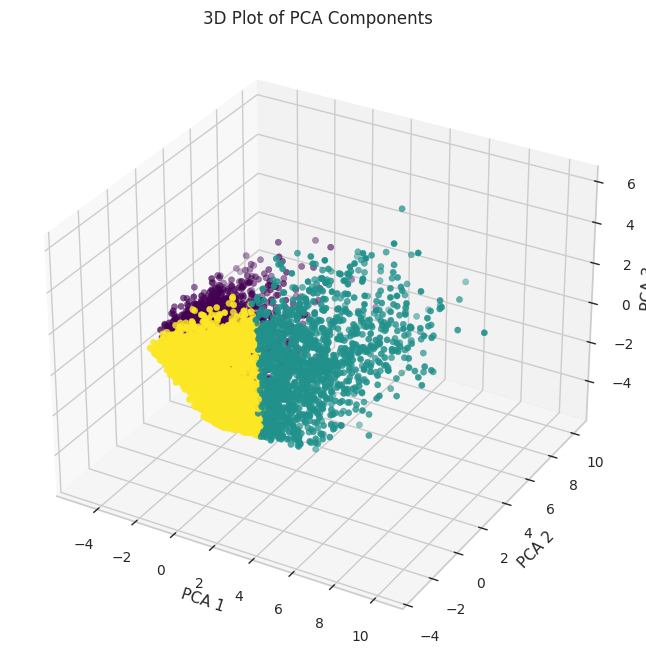

In [18]:
# 3D plot of the 3 PCA
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_cleaned_components[:, 0], pca_cleaned_components[:, 1], pca_cleaned_components[:, 2], c=clusters, cmap='viridis')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.title('3D Plot of PCA Components')
plt.show()

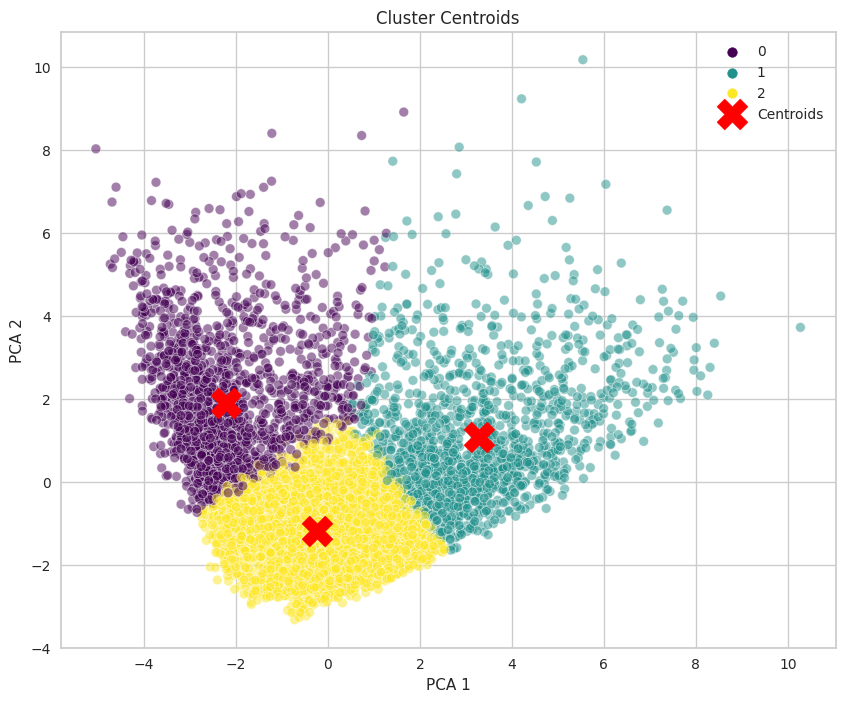

In [19]:
# Get the centroids
centroids = km.cluster_centers_


# Plot 2 PCA values to see the boundaries of the 3 clusters
plt.figure(figsize=(10, 8))

sns.scatterplot(x=pca_cleaned_components[:, 0], y=pca_cleaned_components[:, 1], hue=clusters, palette='viridis', alpha=0.5)

plt.scatter(centroids[:, 0], centroids[:, 1], s=500, c='red', label='Centroids', marker='X')
plt.title('Cluster Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

In [20]:
# Assign the clusters to analyze what features are being assigned to what clusters to label them
data_cleaned['Cluster'] = clusters
cluster_profiles = data_cleaned.groupby('Cluster').mean()
print(cluster_profiles)

             BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                                  
0        2755.563273           0.955040   243.340869        156.783778   
1        1400.788014           0.970416  2381.479485       1450.238413   
2         655.161771           0.862557   419.703782        199.055518   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                     86.577335   2215.379632             0.190155   
1                    931.308058    297.779168             0.910112   
2                    221.103118    176.382297             0.474915   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
0                          0.084720                          0.112746   
1                          0.540408                        

/tmp/ipykernel_18/1934072411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Cluster'] = clusters


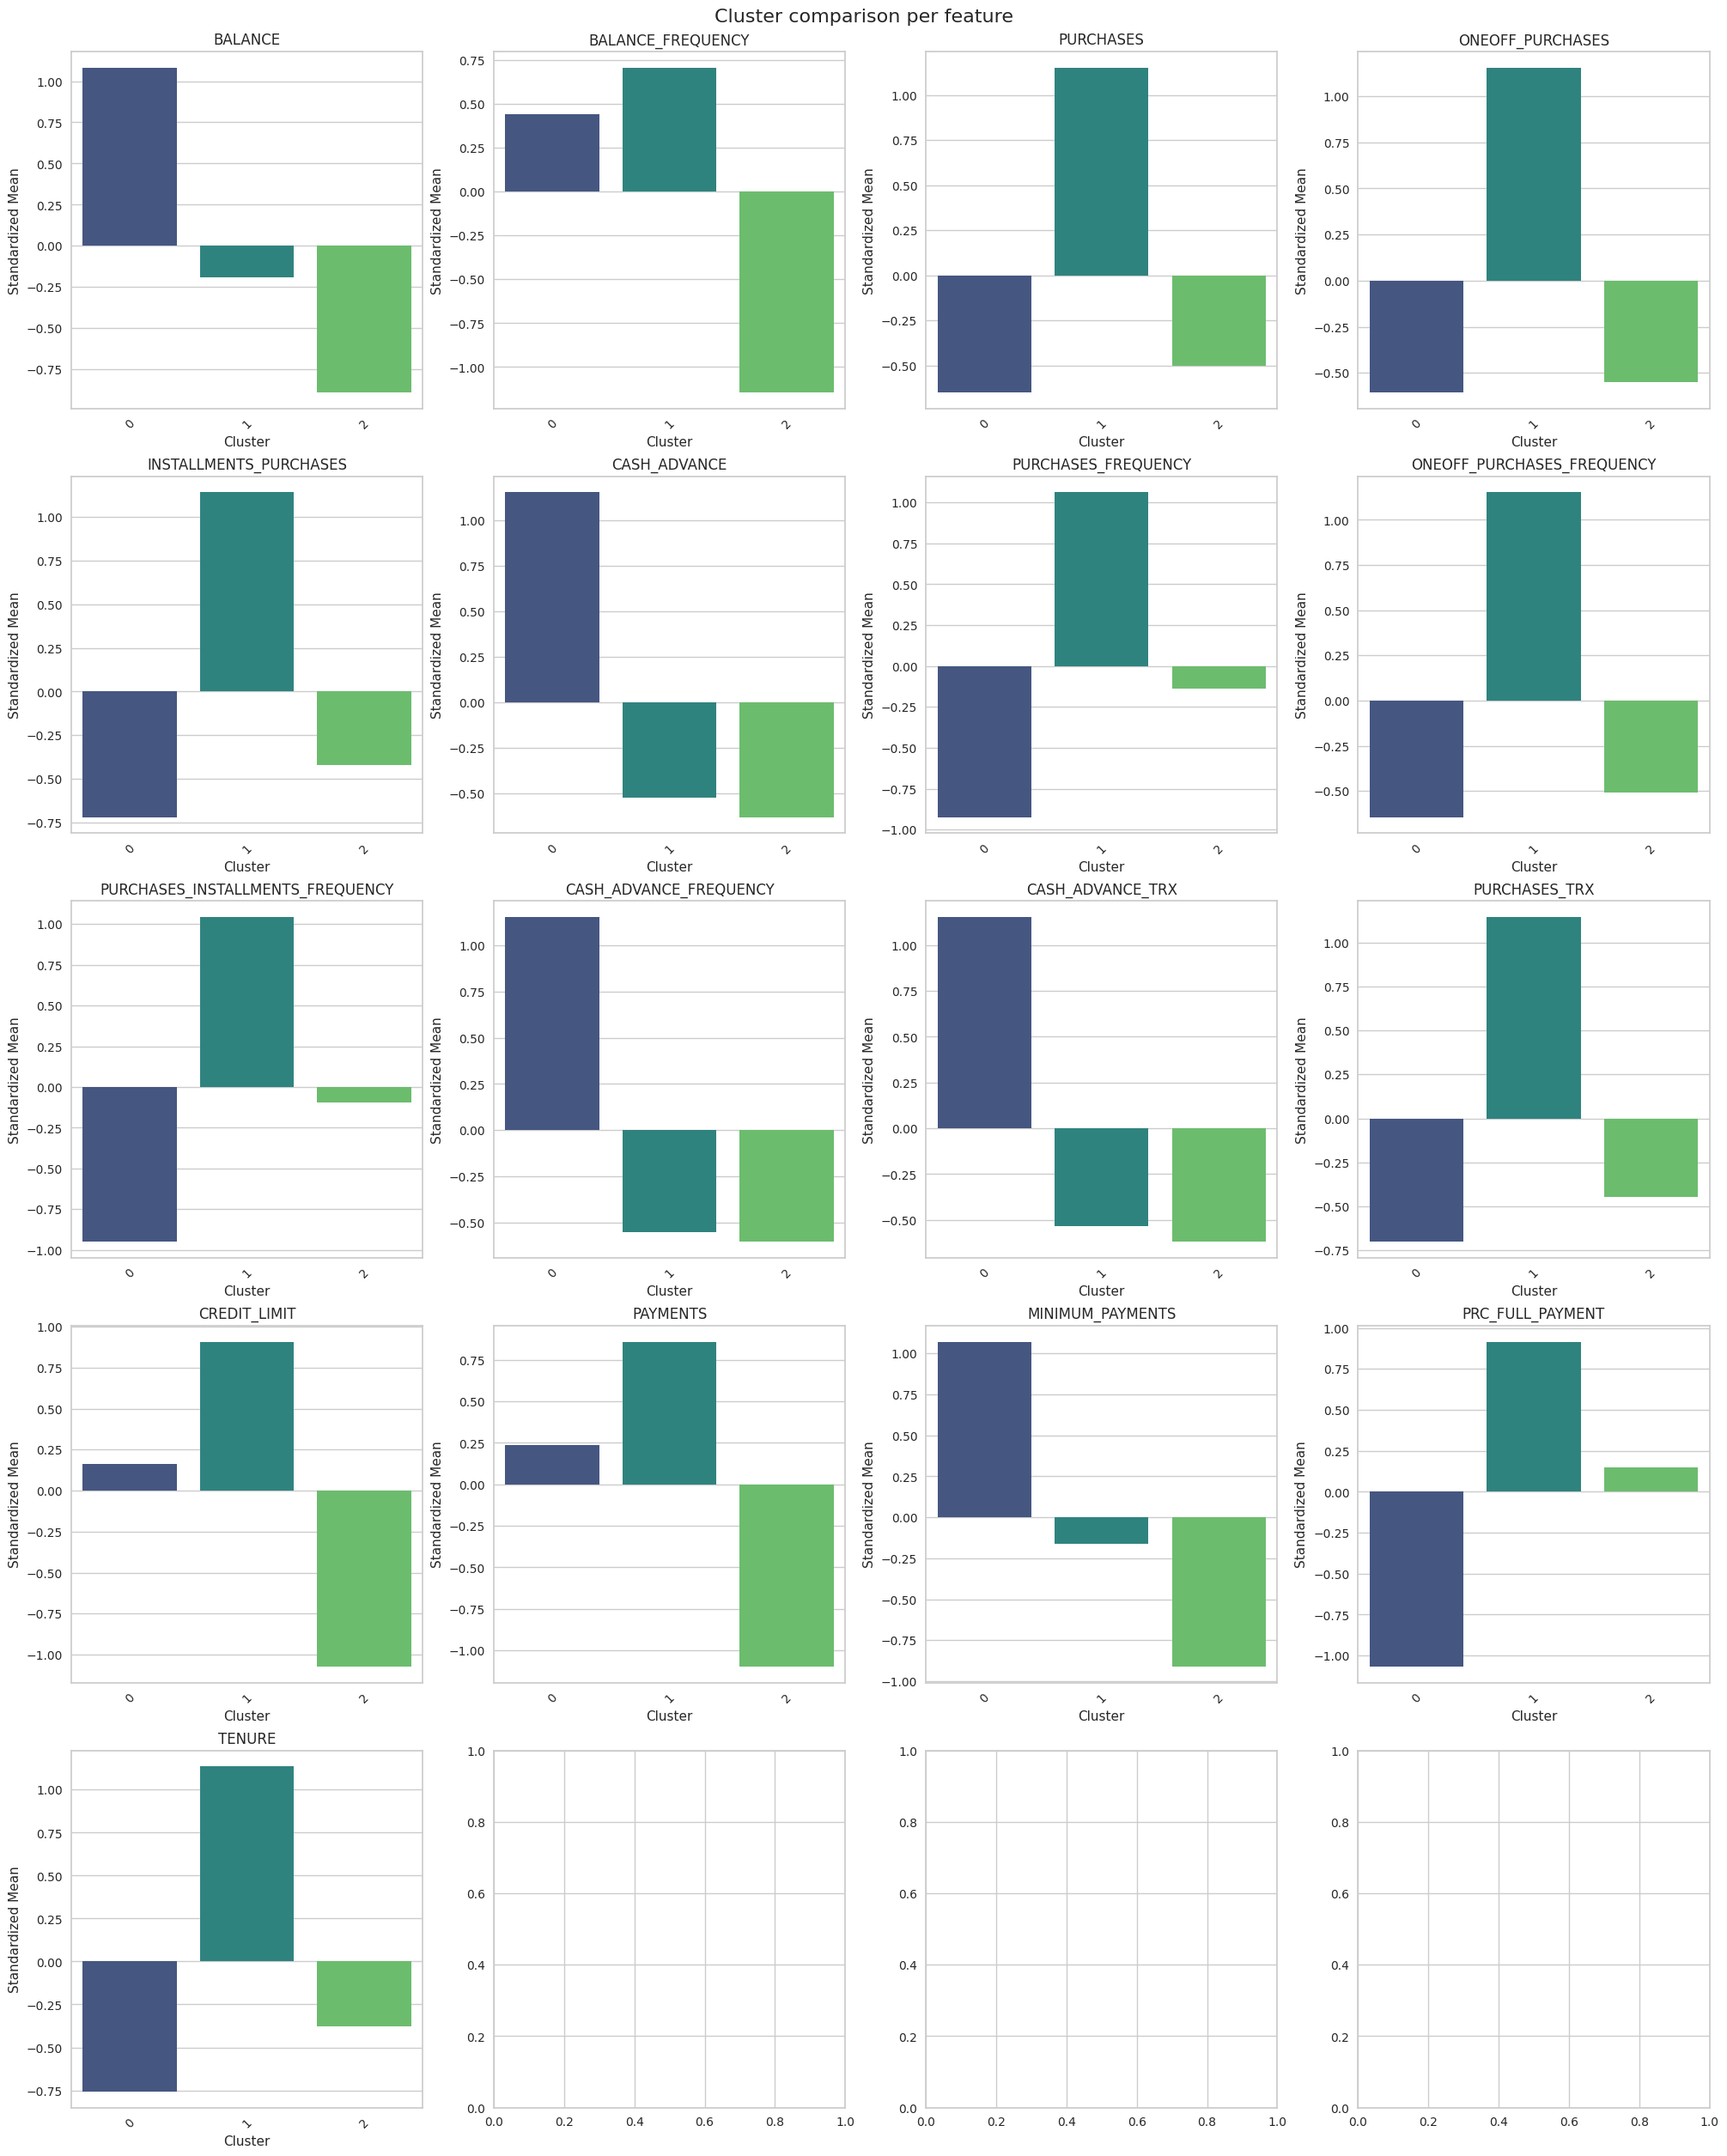

In [21]:
# Standardize the data, and then plot all features to see the differences
z_cluster_profiles = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
num_rows = (len(z_cluster_profiles.columns) // 4) + 1
num_cols = min(len(z_cluster_profiles.columns), 4)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows), constrained_layout=True)
fig.suptitle('Cluster comparison per feature', fontsize=16)

for i, feature in enumerate(z_cluster_profiles.columns):
    row = i // num_cols
    col = i % num_cols
    if len(z_cluster_profiles.columns) > 4:
        ax = axes[row, col]
    else:
        ax = axes[i] if len(z_cluster_profiles.columns) > 1 else axes
    
    sns.barplot(x=z_cluster_profiles.index, y=z_cluster_profiles[feature], ax=ax, palette='viridis')
    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Standardized Mean')
    ax.tick_params(axis='x', rotation=45)

plt.show()

# Conclusion

Given the visualizations of the 3 clusters, we can dissect what is distinct of each cluster.

Cluster 0:
* Very high balance
* High cash advance
* Low purchase frequency
* Low purchase installments frequency
* High cash advance frequency
* High cash advance transaction
* High minimum payments
* Low full payment
* Low tenure

Cluster 1:
* High purchases
* High installment purchases
* High purchase frequency
* High one off purchase frequency
* High purchase installments frequency
* High purchases transactions
* High credit limit
* High payments
* High full payments
* High tenure

Cluster 2:
* Low balance
* Low balance frequency
* Low credit limit
* Low payments
* Low minimum payments

Cluster 0 appears to be people that unfortunately run a very high balance on the credit cards and are making minimum payments, therefore running a high balance. Due to this, they also need things like cash advances and don't make purchases as often as the other groups.

Cluster 1 appears to be the complete opposite of cluster 0 and is people that make a lot of purchases but pay off their balance in full typically. They have a longer length of credit in terms of tenure and a higher credit limit as a result.

Cluster 2 appears to be the group in between these two. They are near the average on most features, but they tend to have a lower balance that doesn't change as much (shown in low balance frequency). In general, these are people that are making few payments/minimum payments, so really they don't use their credit card that much as a whole.

Given these characteristics, while not perfect, I think I was able to correctly identify and cluster 3 separate groups of credit card users fairly well. This is with a silhouette score of .21 as well, so even though the boundaries may not be as well defined as they could be, in general I think it works well enough that this could be used in different applications to identify at-risk credit users, wealthy users, and users that don't use credit that much.